## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [139]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from leaflet import *

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [82]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBBS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(1)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1008
+----------------+------------------+------------------+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
|         coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|               res_1|               res_2|               res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+----------------+------------------+------------------+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
|5236.56372535678|-524.2927399414926|28.596229640472146|    454.2|SBBBBBBS| 47.2256| -97.1919|       SNWD|0.029431655415476356|0.019702368195064147|0.019673424705629834|0.5650322126472471

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00214106| 47.2256| -97.1919|    454.2|  5236.56372535678|
|USC00325220| 46.4386| -97.6856|    337.4|2811.6614748920815|
|USC00216276| 46.4314| -95.5464|    298.7| 4874.836613197419|
|USW00094967| 46.9006| -95.0678|    437.1| 5006.399613388321|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
18,US1MNCY0001,46.8877,-96.7480,275.5,1,1307.721262
34,USC00210018,47.2992,-96.5161,276.5,23,491.832046


In [50]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    #print x
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#90ff66'

In [67]:
print get_color(_min)
print get_color(_max)
print get_color((_min+_max)/2)

#000080
#800000
#7dff7a


## Map

In [9]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)


In [140]:
min_long = -98.8667
min_lat = 46.3939
max_long = -95.0161
max_lat = 47.8769
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
min_c, max_c = 0, 0
m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
data = {}
#lat_margin=(max_lat-min_lat)/4
#long_margin=(max_long-min_long)/4
circles = []
min_l, min_la, max_l, max_la = 0, 0, 0, 0
for i, (index,row) in enumerate(pdf.iterrows()):
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    min_c = min(_coef, min_c)
    max_c = max(_coef, max_c)
    if int(_coef) == -584 or int(_coef) == 2425:
        print 'extremes', row['station'], _count
    if not i:
        min_l = max_l = _long
        min_la = max_la = _lat
    data[_coef] = (_count, row['station'], get_color(_coef))
    min_l = min(min_l, _long) 
    max_l = max(max_l, _long) 
    min_la = min(min_la, _lat) 
    max_la = max(max_la, _lat) 
    #print _coef, _count
    #print get_color(_coef)
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(700*np.sqrt(_count+0.0)), weight=2,
            color='#F00', opacity=0.9, fill_opacity=0.5, stroke=False,
            fill_color=get_color(_coef))
    circles.append(c)
    cc = CircleMarker(circle=c)
    #m.add_layer(c)
    m += c
    m += cc
#print min_l, min_la, max_l, max_la
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r
m    
#dir(circles[0])

extremes USC00323665 4
extremes USC00326565 1


In [138]:
data

{-584.0004840174835: (4L, u'USC00323665', u'#000080'),
 -361.7523296075113: (11L, u'USC00213104', u'#0000d1'),
 -250.7539470033087: (3L, u'USC00321477', u'#0000ff'),
 -223.50283287033196: (17L, u'USC00320196', u'#0000ff'),
 -212.865530970341: (17L, u'USC00320005', u'#0000ff'),
 -160.4051767404241: (1L, u'USC00322536', u'#0010ff'),
 -91.01439672615614: (30L, u'USC00215589', u'#0024ff'),
 -82.07617473570808: (14L, u'USC00325764', u'#0028ff'),
 -71.5753518120672: (17L, u'USC00328937', u'#002cff'),
 -61.70706535040066: (10L, u'USC00324418', u'#0030ff'),
 -19.64876817230738: (10L, u'USC00324656', u'#0040ff'),
 -19.204385328168236: (20L, u'USC00321816', u'#0040ff'),
 -16.431471456492492: (17L, u'USC00325220', u'#0040ff'),
 -16.124799613760864: (37L, u'USW00014914', u'#0040ff'),
 7.424736947985166: (37L, u'USC00325660', u'#0048ff'),
 23.802305602604186: (29L, u'USW00014919', u'#004cff'),
 24.322293738457738: (14L, u'USC00329185', u'#004cff'),
 52.60008154148713: (13L, u'USC00324203', u'#0058f

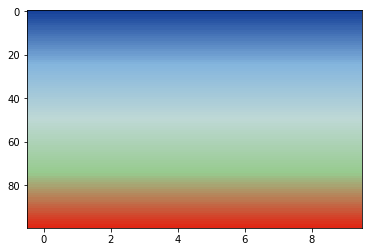

In [136]:
from matplotlib import pyplot as plt
import matplotlib 
import numpy as np

plt.figure()
a=np.outer(np.arange(0,1,0.01),np.ones(10))
fact = 1.0/255.0
cdict2 = {'red':  [(0.0,   22*fact,  22*fact),
                   (0.25, 133*fact, 133*fact),
                   (0.5,  191*fact, 191*fact),
                   (0.75, 151*fact, 151*fact),
                   (1.0,   225*fact,  225*fact)],
         'green': [(0.0,   65*fact,  65*fact),
                   (0.25, 182*fact, 182*fact),
                   (0.5,  217*fact, 217*fact),
                   (0.75, 203*fact, 203*fact),
                   (1.0,   38*fact,  38*fact)],
         'blue':  [(0.0,  153*fact, 153*fact),
                   (0.25, 222*fact, 222*fact),
                   (0.5,  214*fact, 214*fact),
                   (0.75, 143*fact, 143*fact),
                   (1.0,   20*fact,  20*fact)]} 
cdict = {'red':   [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'blue':  [(0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  1.0, 1.0)]}
my_cmap2 = matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)
plt.imshow(a,aspect='auto', cmap =my_cmap2)                   
plt.show()

In [119]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),10))
colors

[<Color red>,
 <Color #f13600>,
 <Color #e36500>,
 <Color #d58e00>,
 <Color #c7b000>,
 <Color #a4b800>,
 <Color #72aa00>,
 <Color #459c00>,
 <Color #208e00>,
 <Color green>]

In [51]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 5

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    #m.add_layer(c)
    m += c
    dd = {}
    dd['c'] = _lat
    g = GeoJSON(data=dd)
    m.add_layer(g)

#imageUrl = 'http://www.lib.utexas.edu/maps/historical/newark_nj_1922.jpg'
#imageBounds = [[min_lat, max_lat], [min_long, max_long]];
#i = ImageOverlay(imageUrl=imageUrl, imageBounds=imageBounds, bringToFront=True, location=(max_lat,max_long), weight=1, opacity=0.1)
#m += i
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

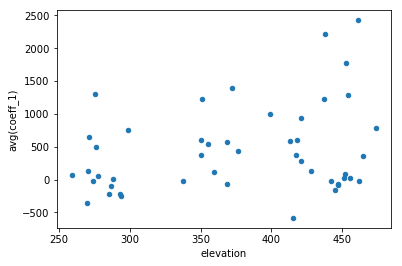

In [86]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

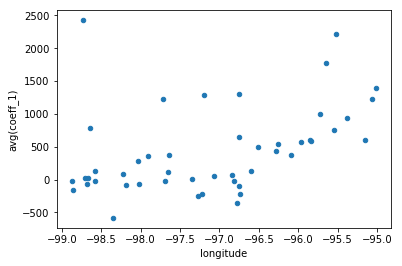

In [71]:
%matplotlib inline
pdf.plot.scatter(x='longitude',y='avg(coeff_1)');

In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']